In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import librosa 
import matplotlib.pyplot as plt
from tqdm import tqdm
from config import *
import h5py
from util import DEFAULT_TOKENS
import librosa

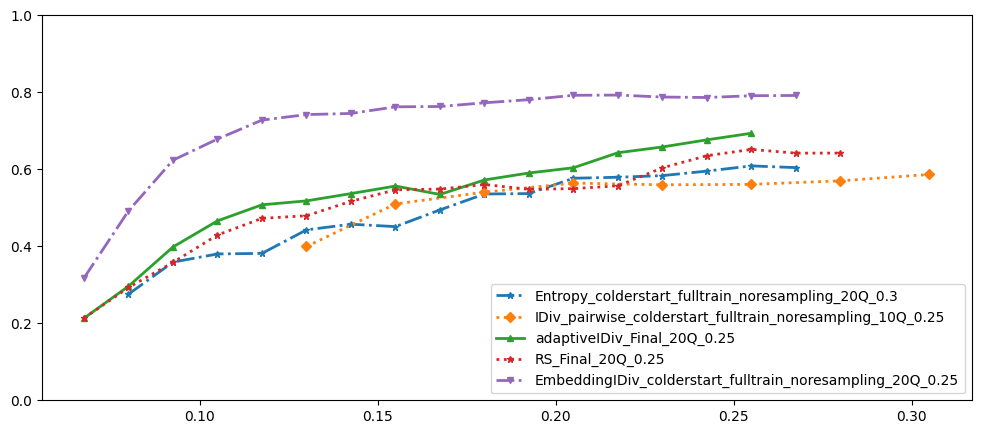

In [32]:
import pickle
from util import LABELS
import random

def plot_files(names):
    for name in names:
        with open(OUTPUT_DIR / 'AL' / name / 'metrics_overwrite.pkl', 'rb') as f:
            c = pickle.load(f)
            plot_map_inc(c)
    plt.legend(names)

def plot_map_inc(LB_metrics):
    x = [lb for lb, _ in LB_metrics]
    AP = np.zeros(shape=(4, len(x)))
    for i, l in enumerate(LABELS):
        # plt.plot(x, apc)
        AP[i] = np.array([m[l]['auc_pr'] for _, (m, mAP) in LB_metrics])
    
    mAP = AP.mean(axis=0)
    # mAP = np.concatenate(([0.07], mAP))
    # x = np.concatenate(([0.02], x))
    marker = random.choice(['o', 's', 'D', '^', 'v', 'x', '*', '+'])
    line_style = random.choice(['-', '--', '-.', ':'])
    
    # Smoothing function
    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    window_size = 4
    av = moving_average(mAP, window_size)
    plt.plot(x[window_size-1:], av, linewidth=2, marker=marker, markersize=5, linestyle=line_style)
    # plt.plot(x, mAP, linewidth=2, marker=marker, markersize=5, linestyle=line_style)
    plt.ylim(0, 1)


plt.figure(figsize=(12, 5))
plot_files([
    'Entropy_colderstart_fulltrain_noresampling_20Q_0.3',
    'IDiv_pairwise_colderstart_fulltrain_noresampling_10Q_0.25',
    # 'adaptive_IDiv_colderstart_fulltrain_noresampling_10Q_0.25',
    'adaptiveIDiv_Final_20Q_0.25',
    # 'RS_colderstart_fulltrain_noresampling_50Q_0.25',
    'RS_Final_20Q_0.25',
    # 'EmbeddingIDiv_colderstart_fulltrain_noresampling_10Q_0.25',
    'EmbeddingIDiv_colderstart_fulltrain_noresampling_20Q_0.25',

])
plt.show() 

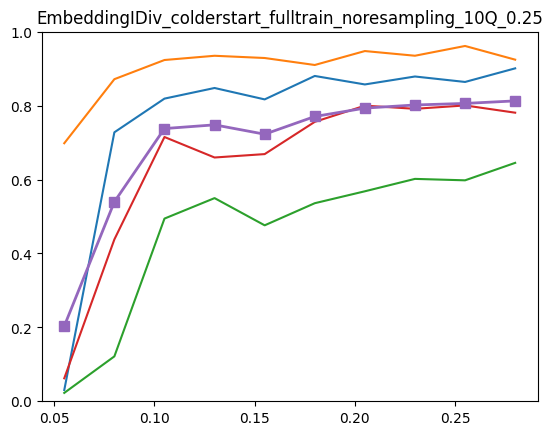

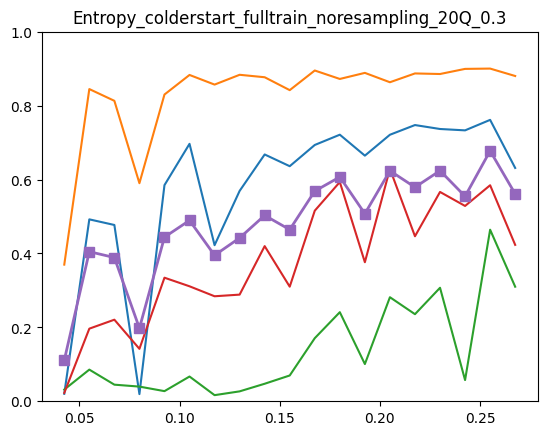

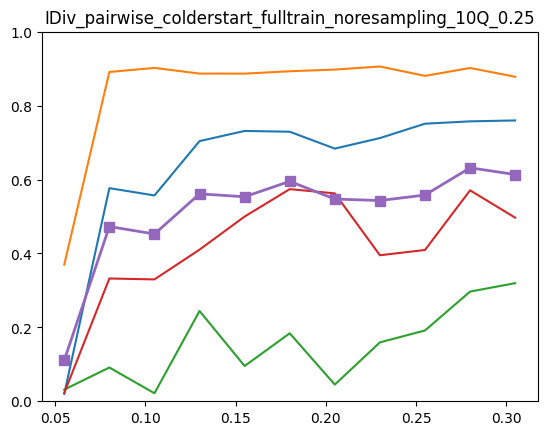

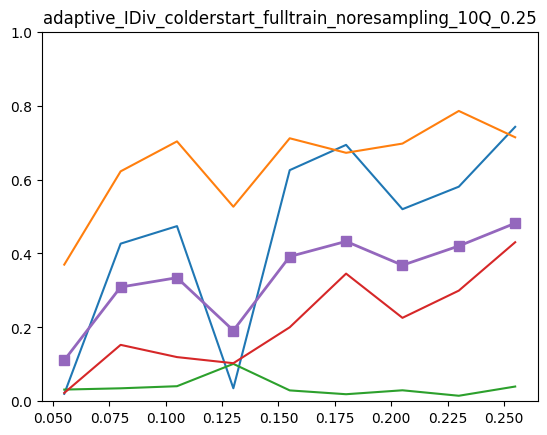

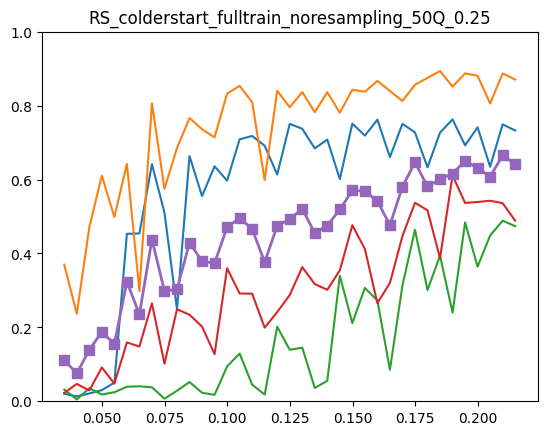

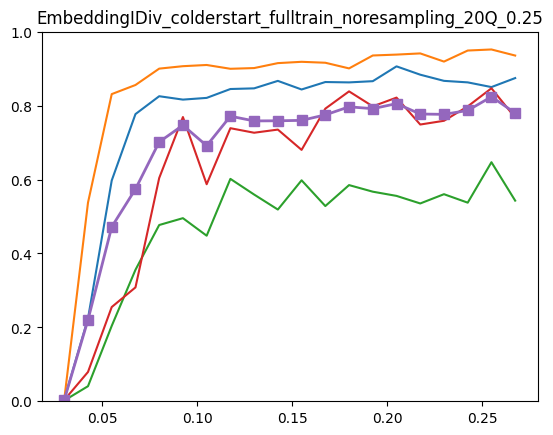

In [4]:
def labelwise_mAP(name):
    with open(OUTPUT_DIR / 'AL' / name / 'metrics_overwrite.pkl', 'rb') as f:
        LB_metrics = pickle.load(f)
        x = [lb for lb, _ in LB_metrics]
        AP = np.zeros(shape=(4, len(x)))
        for i, l in enumerate(LABELS):
            apc = np.array([m[l]['auc_pr'] for _, (m, mAP) in LB_metrics])
            plt.plot(x, apc)
            AP[i] = apc
            
        plt.plot(x, AP.mean(axis=0), linewidth=2, marker='s', markersize=7, linestyle='-')
        plt.title(name)
        plt.ylim(0, 1)


for n in [
    'EmbeddingIDiv_colderstart_fulltrain_noresampling_10Q_0.25',
    'Entropy_colderstart_fulltrain_noresampling_20Q_0.3',
    'IDiv_pairwise_colderstart_fulltrain_noresampling_10Q_0.25',
    'adaptive_IDiv_colderstart_fulltrain_noresampling_10Q_0.25',
    'RS_colderstart_fulltrain_noresampling_50Q_0.25',
'EmbeddingIDiv_colderstart_fulltrain_noresampling_20Q_0.25']:
    labelwise_mAP(n)
    plt.show()


In [20]:
X = np.load(INTERMEDIATE / 'logmel_multiclass_noise.npy')
Y = np.load(INTERMEDIATE / 'logmel_labels_multiclass_noise.npy')

In [21]:
len(X)

211636

In [14]:
features = np.array([
    librosa.feature.mfcc(S=x, n_mfcc=11).flatten() for x in X
])

In [16]:
from sklearn.cluster import MiniBatchKMeans

# initial random data
i = np.random.choice(range(len(features)), 10_000)
X_subsampled = features[i]

# Define the number of clusters
n_clusters = 5

# Initialize MiniBatchKMeans
mb_kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=1000)

# Fit the model on the subsampled dataset
mb_kmeans.fit(X_subsampled)

MiniBatchKMeans(batch_size=1000, n_clusters=5)

In [17]:
# Predict cluster labels for the subsampled data
labels = mb_kmeans.predict(X_subsampled)

In [18]:
# If you want to assign the remaining data to clusters:
remaining_labels = mb_kmeans.predict(features)

In [19]:
remaining_labels

array([4, 1, 0, ..., 1, 3, 0], dtype=int32)

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(features)

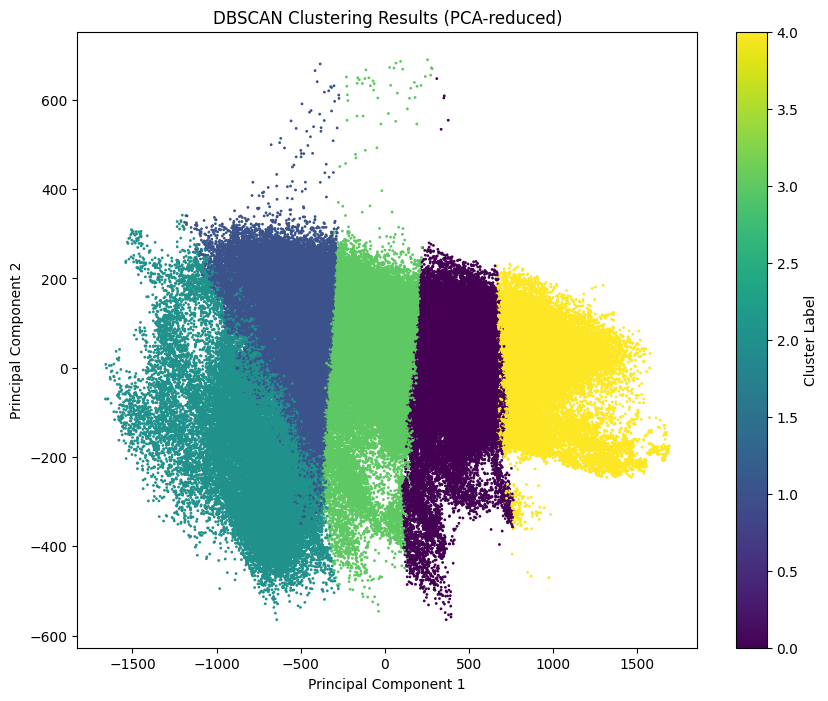

In [34]:
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=remaining_labels, cmap='viridis', s=1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [ ]:
labels_n = np.argmax(Y, axis=1)

flat_X = np.array([x.flatten() for x in X])

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(flat_X)

plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels_n, cmap='viridis', s=1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

array([4, 4, 4, ..., 4, 4, 4])

In [6]:
def _embeddings_prediction(model, X):
    embs_layer = model.layers[-2]
    embs_model = Model(inputs=model.input, outputs=[embs_layer.output, model.output])
    embs, preds =  embs_model.predict(X, verbose=2)
    return embs, preds    


import keras_cv
from keras import Model
from AL import *

model = build_resnet16((40, 107, 1)) 
model.compile(
    optimizer='adam',
    loss=keras_cv.losses.FocalLoss(alpha=0.25, gamma=2)
)

e, p = _embeddings_prediction(model, X[:10])

1/1 - 1s - 627ms/step


In [13]:
e.shape, p.shape

((10, 64), (10, 5))

In [ ]:
from sklearn.metrics.pairwise import *

def _embeddings_prediction(model, X):
    embs_layer = model.layers[-2]
    embs_model = Model(inputs=model.input, outputs=[embs_layer.output, model.output])
    embs, preds =  embs_model.predict(X, verbose=2)
    return embs, preds    
    
def selective_embedding_diversity(model, pool_X, n_instances=5, selection_factor=10):
    # entropy sampling    
    embeddings, probabilities = _embeddings_prediction(model, pool_X)
    entropy_values = -np.sum(probabilities * np.log(probabilities + 1e-10), axis=1)
    uncertain_indices = np.argsort(entropy_values)[-n_instances:]
    uncertain_embeddings = embeddings[uncertain_indices]
    
    # pairwise dist on embeddings
    p = pairwise_distances(uncertain_embeddings, uncertain_embeddings)
    av_similarity = p.mean(axis=1)
    
    # convert to diversity
    diversities = 1 / (1 + av_similarity)
    selected_indices = np.argsort(-diversities)[:n_instances]
    i = uncertain_indices[selected_indices]
    return i, pool_X[i] 


i, x = selective_embedding_diversity(model, X)

In [ ]:
from sklearn.cluster import DBSCAN

# Step 1: Initialize DBSCAN
dbscan = DBSCAN(eps=20, min_samples=5)

# Step 2: Fit the model
dbscan.fit(embs)

# Step 3: Get cluster labels
dbscan_labels = dbscan.labels_

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(embs)

In [82]:
[np.where(p)[0][0] for p in labelled_p[:3] > 0.5]

[1, 1, 1]

/tmp/ipykernel_12279/2873521571.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=c, cmap='viridis', s=1)


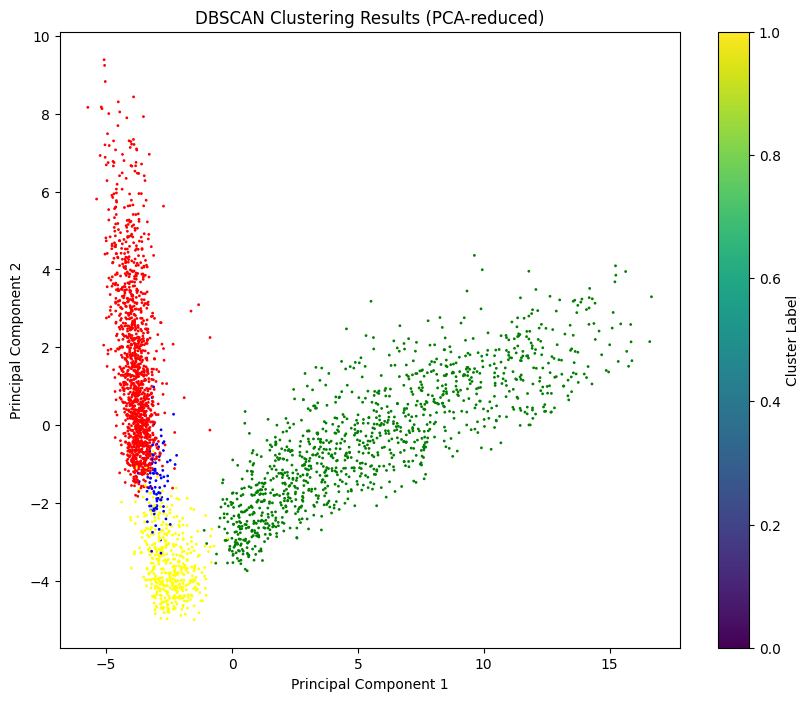

In [85]:
# Optional: Visualize the results

ccs = ['red', 'green', 'blue', 'yellow']
c = [ccs[np.where(p)[0][0]] for p in preds > 0.5]

plt.figure(figsize=(10, 8))

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=c, cmap='viridis', s=1)
plt.title('DBSCAN Clustering Results (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [7]:
X[0]

array([[-13.9496765, -14.961968 , -17.355728 , ..., -13.065759 ,
        -16.908432 , -16.852089 ],
       [-12.917692 , -14.850504 , -16.275633 , ..., -19.418045 ,
        -19.371677 , -17.611155 ],
       [-12.995191 , -15.562256 , -13.831994 , ..., -18.966063 ,
        -14.257493 , -12.350352 ],
       ...,
       [-15.100581 , -14.42197  , -16.875446 , ..., -20.155708 ,
        -23.553577 , -28.237476 ],
       [-32.68812  , -32.666183 , -32.25553  , ..., -34.15206  ,
        -34.2952   , -34.570484 ],
       [-33.76547  , -33.406986 , -32.61069  , ..., -35.13275  ,
        -34.185623 , -35.956642 ]], dtype=float32)

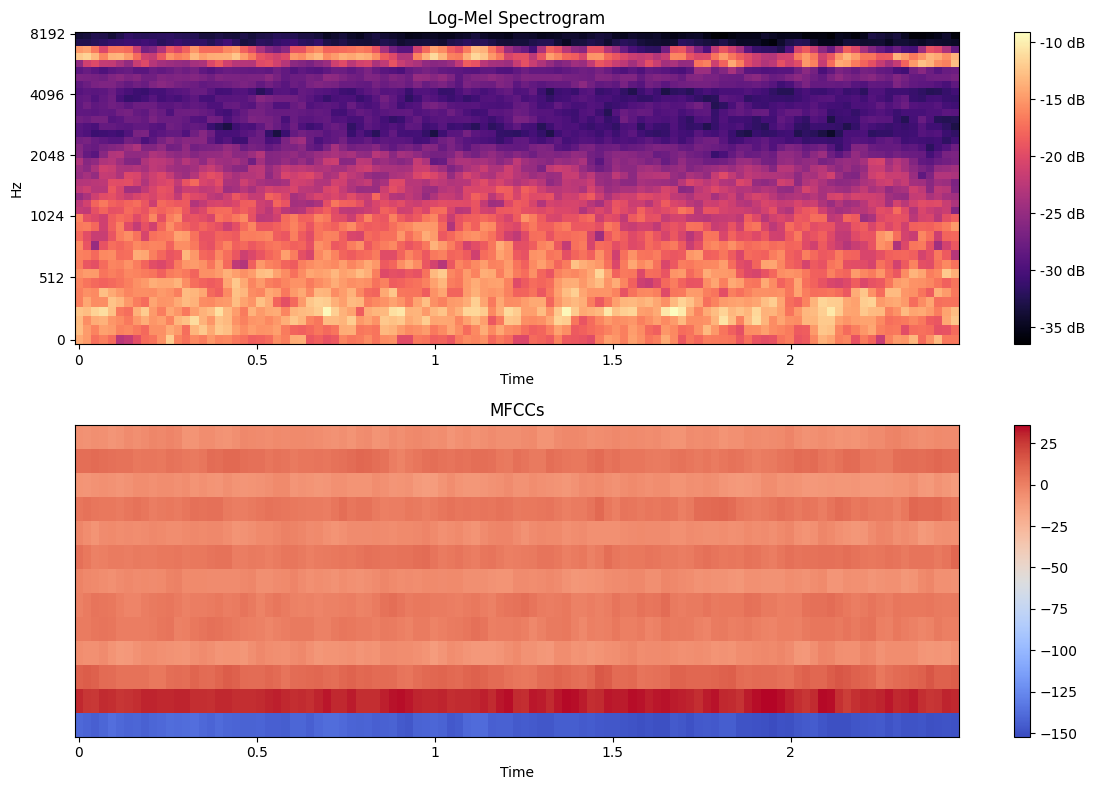

In [12]:

log_mel_spectrogram = X[0]

# Step 3: Compute MFCCs from the log-Mel spectrogram
mfccs = librosa.feature.mfcc(S=log_mel_spectrogram, n_mfcc=13)

# Optional: Visualize the log-Mel spectrogram and MFCCs
plt.figure(figsize=(12, 8))

# Log-Mel Spectrogram
plt.subplot(2, 1, 1)
librosa.display.specshow(log_mel_spectrogram, x_axis='time', y_axis='mel', fmax=8000)
plt.title('Log-Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')

# MFCCs
plt.subplot(2, 1, 2)
librosa.display.specshow(mfccs, x_axis='time')
plt.title('MFCCs')
plt.colorbar()

plt.tight_layout()
plt.show()

In [13]:
mfccs.shape

(13, 107)

In [16]:

del mfccs
features = np.array([
    librosa.feature.mfcc(S=logmel, n_mfcc=20).flatten()
    for logmel in X
])


In [18]:
from sklearn_extra.cluster import KMedoids

kmedoids = KMedoids(n_clusters=5, random_state=0)
kmedoids.fit(features)

# Get the cluster labels
labels = kmedoids.labels_

MemoryError: Unable to allocate 167. GiB for an array with shape (211636, 211636) and data type float32

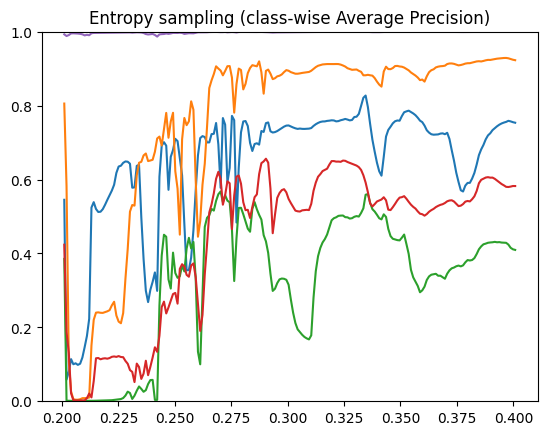

In [47]:

from util import *
from AL import *

with open('IDiv_pairwise_colderstart_fulltrain_noresampling_10Q_0.25' ,rb) as f:
    f.

LB_metrics = m
identity = 'entropy'
# AP curves
x = [lb for lb, _ in LB_metrics]
for i, l in enumerate(MULTICLASS_LABELS):
    # y = [m[l]['recall'] for _, (m, mAP) in LB_metrics] 
    # title = f'AP of {l} for {identity}'
    # plt.plot(x, y)

    # y = [m[l]['precision'] for _, (m, mAP) in LB_metrics] 
    # title = f'AP of {l} for {identity}'
    # plt.plot(x, y)

    y = [m[l]['auc_pr'] for _, (m, mAP) in LB_metrics] 
    title = f'AP of {l} for {identity}'
    plt.plot(x, y)

    
plt.ylim(0, 1)
plt.title('Entropy sampling (class-wise Average Precision)')
plt.show()




In [4]:
# mAP curve
AP = np.zeros(shape=(4, len(x)))
for i, l in enumerate(LABELS):
    AP[i] = np.array([m[l]['auc_pr'] for _, (m, mAP) in LB_metrics])

title = f'mAP for {identity}'
plt.figure(figsize=(20, 5))
plt.plot(x, AP.mean(axis=0))
plt.ylim(0, 1)
plt.title(title)
plt.show()

NameError: name 'x' is not defined

In [19]:
with open('../../output/AL/archive/RS (oversampled)/RS_metrics_oversampled.pkl', 'rb') as f:
    m2 = pickle.load(f)

In [29]:
LABELS

['fast_trill_6khz', 'nr_syllable_3khz', 'triangle_3khz', 'upsweep_500hz']

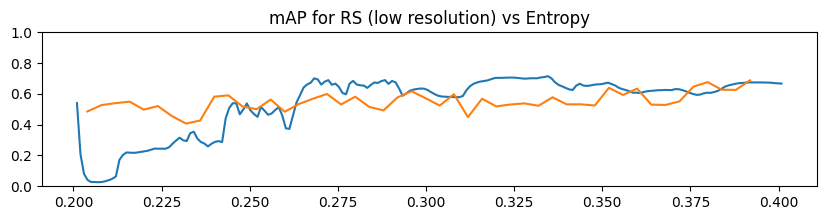

In [43]:
AP = np.zeros(shape=(4, len(x)))
AP_RS = np.zeros(shape=(4, len(m2)))

xx = [lb for lb, m in m2]

for i, l in enumerate(LABELS):
    AP[i] = np.array([m[l]['auc_pr'] for _, (m, mAP) in LB_metrics])
    AP_RS[i] = np.array([m[l]['auc_pr'] for _, m in m2])


title = f'mAP for RS (low resolution) vs Entropy'
plt.figure(figsize=(10, 2))

plt.plot(x, AP.mean(axis=0))

cap = int(0.25 * len(xx))
plt.plot(xx[ :cap], AP_RS.mean(axis=0)[:cap])

plt.ylim(0, 1)
plt.title(title)
plt.show()